In [1]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import random
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import mapply
mapply.init(n_workers=7, progressbar=True)
import pickle
with open('scaler.pickle', 'rb') as f:
    scaler: StandardScaler = pickle.load(f)

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [201]:
def prepare(df, remove_outliers=True, with_indicators=True):
    cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party', 'CLEAN', 'OUTLIER']

    orig_num_cols = ['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
            'max_age_participants', 'n_participants_child', 'n_participants_teen',
            'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
            'n_arrested', 'n_unharmed', 'n_participants', 'timestamp',
            'povertyPercentage', 'candidatevotes', 'totalvotes']

    if 'latitude' not in df.columns:
        orig_num_cols = [s for s in orig_num_cols if s != 'latitude']
    if 'longitude' not in df.columns:
        orig_num_cols = [s for s in orig_num_cols if s != 'longitude']

    if remove_outliers:
        df = df[df['OUTLIER'] == 0]

    df.loc[:, cat_cols] = df.loc[:, cat_cols].astype('object')#df[cat_cols] = df[cat_cols].astype('object')
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    if not with_indicators:
        numerical_df = numerical_df[orig_num_cols]

    scaler = StandardScaler()
    numerical_scaled = scaler.fit_transform(numerical_df)
    numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical_df.columns)

    return numerical_df, numerical_scaled, scaler


def features_reduction_corr(df, correlation_threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify highly correlated features
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Remove highly correlated features
    df_filtered = df.drop(columns=highly_correlated_features)
    return df_filtered


def features_reduction_var(df, variance_threshold=2):
    # Compute the variance of each feature
    feature_variances = df.var()

    # Identify features below the variance threshold
    low_variance_features = feature_variances[feature_variances < variance_threshold].index

    # Prune (remove) features below the threshold
    df_pruned = df.drop(columns=low_variance_features)

    return df_pruned


def k_means(df, k_min, k_max, initial_centroids=None, max_iter=300):
    models = []
    for i in range(k_min):
        models.append(None)

    for k in tqdm(range(k_min, k_max+1)):
        if initial_centroids is None:
            model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter)
        else:
            model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter, init=initial_centroids)
        model.fit(df)
        models.append(model)

    return models


def scores(models, df, k_min, k_max, sample_size=-1, n_samples=1):
    SSEs = []
    separations = []
    silhouettess = []

    for i in range(0, k_min):
        SSEs.append(None)
        separations.append(None)
        silhouettess.append([])
    
    models = models[k_min:k_max+1]

    k = k_min

    for model in models:

        print(f'k = {k}')

        SSEs.append(model.inertia_)
        separations.append(metrics.davies_bouldin_score(df, model.labels_))

        silhouettes = []
        for j in tqdm(range(0, n_samples)):
            if sample_size == -1:
                sample_size = df.shape[0]   
            sampled_indeces = random.sample(range(df.shape[0]), sample_size)
            sampled_points = [df.iloc[i] for i in sampled_indeces]
            sampled_labels = [model.labels_[i] for i in sampled_indeces]
            silhouettes.append(silhouette_score(sampled_points, sampled_labels))
        silhouettess.append(silhouettes)

        k += 1
    
    scoress_dict = {
        'SSE': SSEs,
        'Separation': separations,
        'Silhouette': silhouettess
    }

    return scoress_dict


def perform_PCA(df, centroids=None, n_components=2):
    pca = PCA(n_components=n_components)

    points_pca = pca.fit_transform(df)
    if centroids is not None:
        centroids_pca = pca.transform(centroids)
        return points_pca, centroids_pca
    return points_pca


def find_features(df, columns, col_scores, threshold=0.1):
    prev_max_score = max(col_scores)
    actual_cols = [columns.pop(0)]
    
    for col in columns:
        actual_cols.append(col)
        scores, _, _ = k_means(df=df[actual_cols], n_samples=1, sample_size=10000, k_min=2, k_max=10)
        max_score = max(scores)
        if np.abs(prev_max_score - max_score) > 0.1:#prev_max_score > max_score:
            actual_cols.pop()
            print(col + ' discarded')
            print('actual score: ' + str(max_score))
        else:
            if prev_max_score < max_score:
                prev_max_score = max_score
            print(col + ' added')
            print('actual score: ' + str(max_score))
    return actual_cols, prev_max_score


def order_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    columns = numeric_df.columns.tolist()
    #random.shuffle(columns)

    max_scores = []
    for col in columns:
        scores, _, _ = k_means(df=df[[col]], n_samples=1, sample_size=10000, k_min=2, k_max=9)
        max_scores.append(max(scores))

    combined = list(zip(columns, max_scores))
    sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
    sorted_cols = [item for item, score in sorted_combined]
    sorted_scores = [score for item, score in sorted_combined]

    return sorted_cols, sorted_scores


def sample_columns(df, num_columns_to_sample=1):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    df_reduced = numeric_df.sample(n=num_columns_to_sample, axis=1).copy()
    return df_reduced


def show_scores(scores_dict, k_min, k_max):
    k_values = np.arange(k_min, k_max+1)
    fig, axes = plt.subplots(nrows=1, ncols=len(scores_dict), figsize=(15, 3))

    axes[0].plot(k_values, scores_dict['SSE'][k_min:k_max+1])
    axes[0].set_title('SSE')
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('SSE')

    axes[1].plot(k_values, scores_dict['Separation'][k_min:k_max+1])
    axes[1].set_title('Separation')
    axes[1].set_xlabel('Number of clusters')
    axes[1].set_ylabel('Separation')

    mean_scores = []
    silhouettess = scores_dict['Silhouette']
    for k in k_values:
        mean_scores.append(np.mean(np.array(silhouettess[k])))
        
    axes[2].plot(k_values, mean_scores)
    axes[2].set_title('Silhouette')
    axes[2].set_xlabel('Number of clusters')
    axes[2].set_ylabel('Silhouette')

    plt.tight_layout()
    plt.show()

    return mean_scores

Dataset dimentions: (235219, 61)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (190977, 19)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (190977, 51)


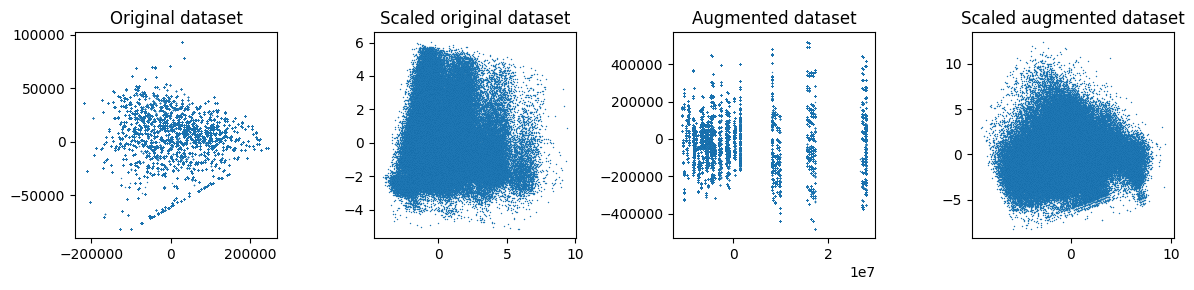

In [78]:
df_init = pd.read_csv('./dataset/data/final_clean2.csv')

df_orig, df_orig_s, scaler_orig = prepare(df_init, remove_outliers=True, with_indicators=False)
df, df_s, scaler = prepare(df_init, remove_outliers=True, with_indicators=True)

print(f'Dataset dimentions: {df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df.shape}')

pca_orig = perform_PCA(df=df_orig, n_components=2)
pca_orig_s = perform_PCA(df=df_orig_s, n_components=2)

pca = perform_PCA(df=df, n_components=2)
pca_s = perform_PCA(df=df_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_orig[:, 0], pca_orig[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 4, 2)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled original dataset')

plt.subplot(1, 4, 3)
plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 4, 4)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled augmented dataset')

plt.tight_layout()
plt.show()

Initial n_cols = 19

Survived columns (variance_threshold = 1):----------------------------------------------
n_cols = 18
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 6
Index(['latitude', 'longitude', 'min_age_participants', 'n_participants_teen',
       'n_killed', 'timestamp'],
      dtype='object')


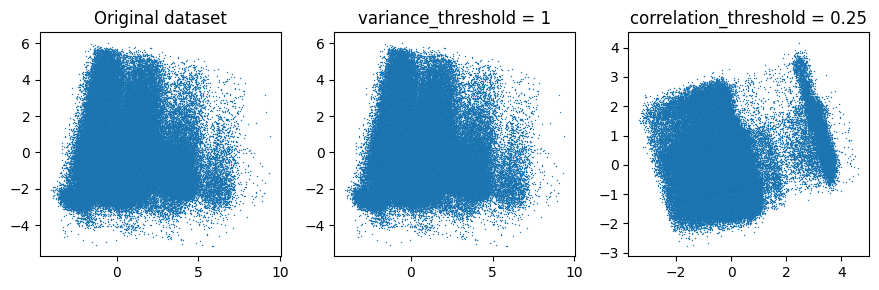

In [79]:
var_thr = 1
reduced_orig_var = features_reduction_var(df_orig_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_orig_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_orig_var.columns)}')
print(reduced_orig_var.columns)

corr_thr = 0.25
reduced_orig = features_reduction_corr(reduced_orig_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_orig.columns)}')
print(reduced_orig.columns)

pca_orig_v = perform_PCA(df=reduced_orig_var, n_components=2)
pca_orig_c = perform_PCA(df=reduced_orig, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_orig_v[:, 0], pca_orig_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_orig_c[:, 0], pca_orig_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

Initial n_cols = 51

Survived columns (variance_threshold = 1):----------------------------------------------
n_cols = 48
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes', 'state_population', 'p_males',
       'p_females', 'p_participants_teen', 'p_participants_adult', 'p_killed',
       'p_injured', 'p_arrested', 'p_unharmed',
       'month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_

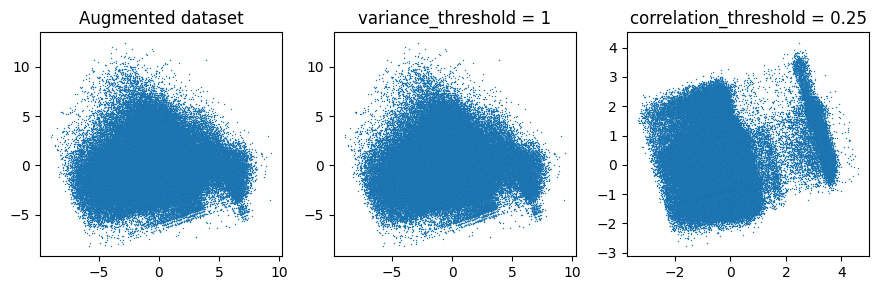

In [80]:
var_thr = 1
reduced_var = features_reduction_var(df_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_var.columns)}')
print(reduced_var.columns)

corr_thr = 0.25
reduced = features_reduction_corr(reduced_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced.columns)}')
print(reduced.columns)

pca_v = perform_PCA(df=reduced_var, n_components=2)
pca_c = perform_PCA(df=reduced, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_v[:, 0], pca_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_c[:, 0], pca_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

#### Without latitude and longitude

Dataset dimentions: (235219, 59)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (190977, 17)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (190977, 49)


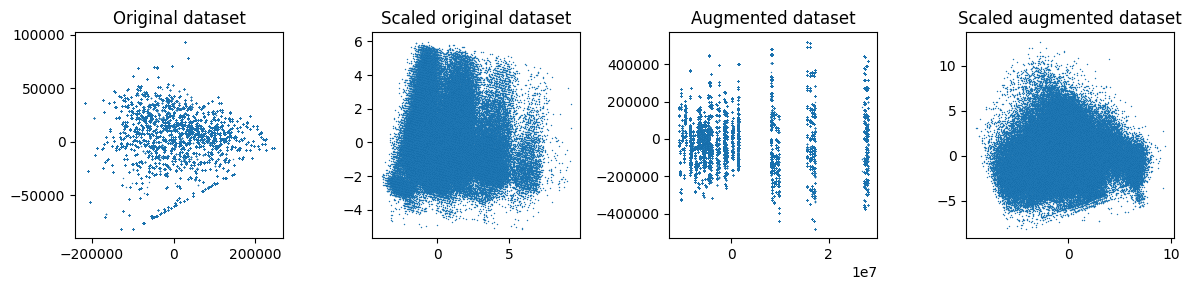

In [81]:
df_nl_init = df_init.drop(columns=['latitude', 'longitude'])
df_nl_orig, df_nl_orig_s, scaler_nl_orig = prepare(df_nl_init, remove_outliers=True, with_indicators=False)
df_nl, df_nl_s, scaler_nl = prepare(df_nl_init, remove_outliers=True, with_indicators=True)


print(f'Dataset dimentions: {df_nl_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_nl_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df_nl.shape}')

pca_nl_orig = perform_PCA(df=df_nl_orig, n_components=2)
pca_nl_orig_s = perform_PCA(df=df_nl_orig_s, n_components=2)

pca_nl = perform_PCA(df=df_nl, n_components=2)
pca_nl_s = perform_PCA(df=df_nl_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_nl_orig[:, 0], pca_nl_orig[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 4, 2)
plt.scatter(pca_nl_orig_s[:, 0], pca_nl_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled original dataset')

plt.subplot(1, 4, 3)
plt.scatter(pca_nl[:, 0], pca_nl[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 4, 4)
plt.scatter(pca_nl_s[:, 0], pca_nl_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled augmented dataset')

plt.tight_layout()
plt.show()

Initial n_cols = 17

Survived columns (variance_threshold = 1):----------------------------------------------
n_cols = 16
Index(['min_age_participants', 'avg_age_participants', 'max_age_participants',
       'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females',
       'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants',
       'timestamp', 'povertyPercentage', 'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 4
Index(['min_age_participants', 'n_participants_teen', 'n_killed', 'timestamp'], dtype='object')


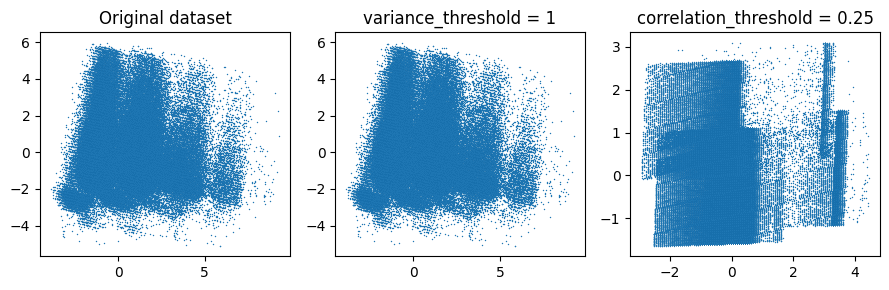

In [82]:
var_thr = 1
reduced_nl_orig_var = features_reduction_var(df_nl_orig_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_nl_orig_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_nl_orig_var.columns)}')
print(reduced_nl_orig_var.columns)

corr_thr = 0.25
reduced_nl_orig = features_reduction_corr(reduced_nl_orig_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_nl_orig.columns)}')
print(reduced_nl_orig.columns)

pca_nl_orig_v = perform_PCA(df=reduced_nl_orig_var, n_components=2)
pca_nl_orig_c = perform_PCA(df=reduced_nl_orig, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_nl_orig_s[:, 0], pca_nl_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_nl_orig_v[:, 0], pca_nl_orig_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_nl_orig_c[:, 0], pca_nl_orig_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

Initial n_cols = 49

Survived columns (variance_threshold = 1):----------------------------------------------
n_cols = 46
Index(['min_age_participants', 'avg_age_participants', 'max_age_participants',
       'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females',
       'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants',
       'timestamp', 'povertyPercentage', 'candidatevotes', 'totalvotes',
       'state_population', 'p_males', 'p_females', 'p_participants_teen',
       'p_participants_adult', 'p_killed', 'p_injured', 'p_arrested',
       'p_unharmed', 'month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_incid

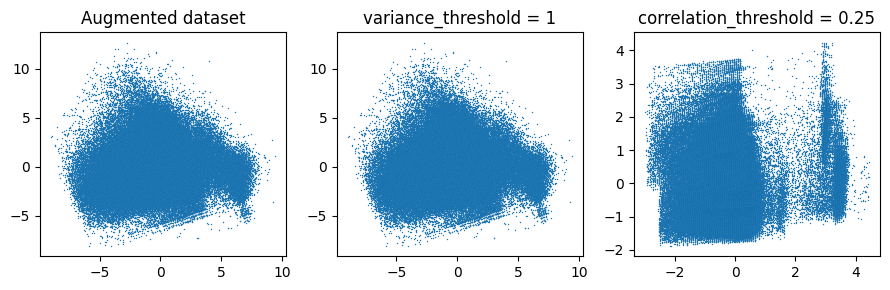

In [83]:
var_thr = 1
reduced_nl_var = features_reduction_var(df_nl_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_nl_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_nl_var.columns)}')
print(reduced_nl_var.columns)

corr_thr = 0.25
reduced_nl = features_reduction_corr(reduced_nl_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_nl.columns)}')
print(reduced_nl.columns)

pca_nl_v = perform_PCA(df=reduced_nl_var, n_components=2)
pca_nl_c = perform_PCA(df=reduced_nl, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_nl_s[:, 0], pca_nl_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_nl_v[:, 0], pca_nl_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_nl_c[:, 0], pca_nl_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

# K-means

### K-means experiments on the original dataset (without outliers)

#### K-means on the full original dataset

In [190]:
k_min = 2
k_max = 10

models = k_means(df_orig_s, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 9/9 [00:39<00:00,  4.44s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:09<00:00,  3.26s/it]


k = 3


100%|██████████| 3/3 [00:07<00:00,  2.34s/it]


k = 4


100%|██████████| 3/3 [00:06<00:00,  2.33s/it]


k = 5


100%|██████████| 3/3 [00:07<00:00,  2.41s/it]


k = 6


100%|██████████| 3/3 [00:07<00:00,  2.44s/it]


k = 7


100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


k = 8


100%|██████████| 3/3 [00:07<00:00,  2.40s/it]


k = 9


100%|██████████| 3/3 [00:06<00:00,  2.29s/it]


k = 10


100%|██████████| 3/3 [00:07<00:00,  2.36s/it]


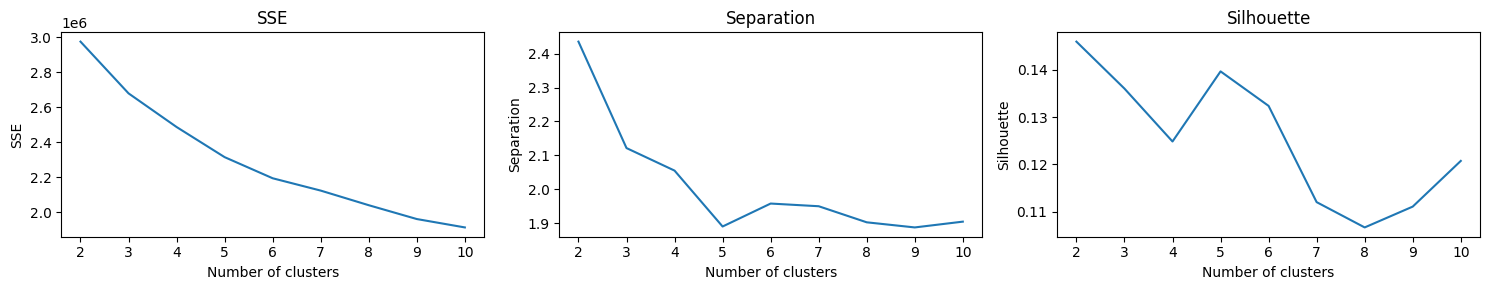

In [203]:
scores_dict = scores(models=models, df=df_orig_s, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

In [205]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=df_orig_s, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:25<00:00, 17.02s/it]


Best mean silhouette score for k = 2:
SSE = 2974152.529572072
Separation = 2.4354565029374227
Silhouette = 0.14557715004294722


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


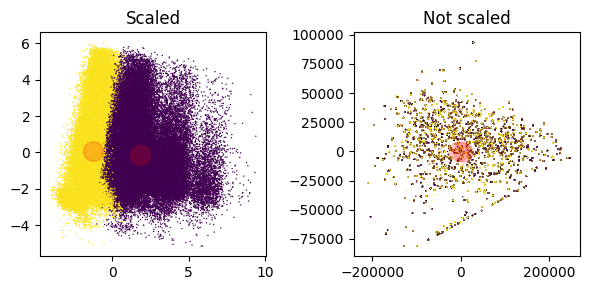

Cluster 0: 177714 points
Cluster 1: 13263 points


In [207]:
best_model_orig = models[best_k]

points_pca_s, centroids_pca_s = perform_PCA(df=df_orig_s, centroids=best_model_orig.cluster_centers_, n_components=2)

orig_points = scaler_orig.inverse_transform(df_orig_s)
orig_centroids = scaler_orig.inverse_transform(best_model_orig.cluster_centers_)

points_pca, centroids_pca = perform_PCA(df=orig_points, centroids=orig_centroids, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=best_model_orig.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', s=200, alpha=0.2)
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model_orig.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(best_model.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### K-means on the reduced original dataset

In [208]:
k_min = 2
k_max = 10

models = k_means(df=reduced_orig, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 9/9 [00:26<00:00,  2.99s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


k = 3


100%|██████████| 3/3 [00:07<00:00,  2.36s/it]


k = 4


100%|██████████| 3/3 [00:06<00:00,  2.33s/it]


k = 5


100%|██████████| 3/3 [00:12<00:00,  4.06s/it]


k = 6


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


k = 7


100%|██████████| 3/3 [00:06<00:00,  2.24s/it]


k = 8


100%|██████████| 3/3 [00:06<00:00,  2.23s/it]


k = 9


100%|██████████| 3/3 [00:09<00:00,  3.01s/it]


k = 10


100%|██████████| 3/3 [00:10<00:00,  3.46s/it]


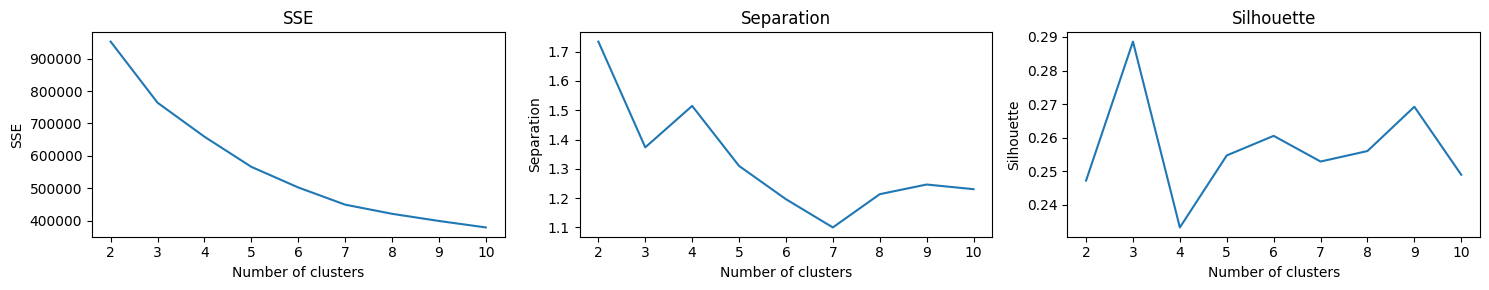

In [210]:
scores_dict = scores(models=models, df=reduced_orig, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

In [211]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=reduced_orig, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

k = 3


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:55<00:00, 11.12s/it]


Best mean silhouette score for k = 3:
SSE = 764004.6328146383
Separation = 1.3732157355973447
Silhouette = 0.2906734960348557


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


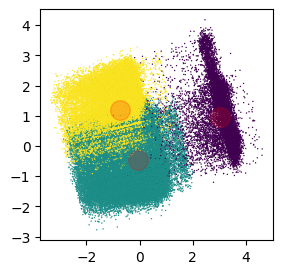

Cluster 0: 13263 points
Cluster 1: 135320 points
Cluster 2: 42394 points


In [212]:
best_model_r_orig = models[best_k]

points_pca, centroids_pca = perform_PCA(df=reduced_orig, centroids=best_model_r_orig.cluster_centers_, n_components=2)

plt.figure(figsize=(3, 3))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model_r_orig.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.show()

cluster_labels, cluster_counts = np.unique(best_model_r_orig.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

### K-means experiments on the augmented (i.e. with indicators) dataset (without outliers)

#### K-means on the full augmented dataset

In [217]:
k_min = 2
k_max = 10

models = k_means(df=df_s, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 9/9 [01:01<00:00,  6.84s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:07<00:00,  2.35s/it]


k = 3


100%|██████████| 3/3 [00:08<00:00,  2.90s/it]


k = 4


100%|██████████| 3/3 [00:11<00:00,  3.90s/it]


k = 5


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


k = 6


100%|██████████| 3/3 [00:07<00:00,  2.41s/it]


k = 7


100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


k = 8


100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


k = 9


100%|██████████| 3/3 [00:12<00:00,  4.24s/it]


k = 10


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


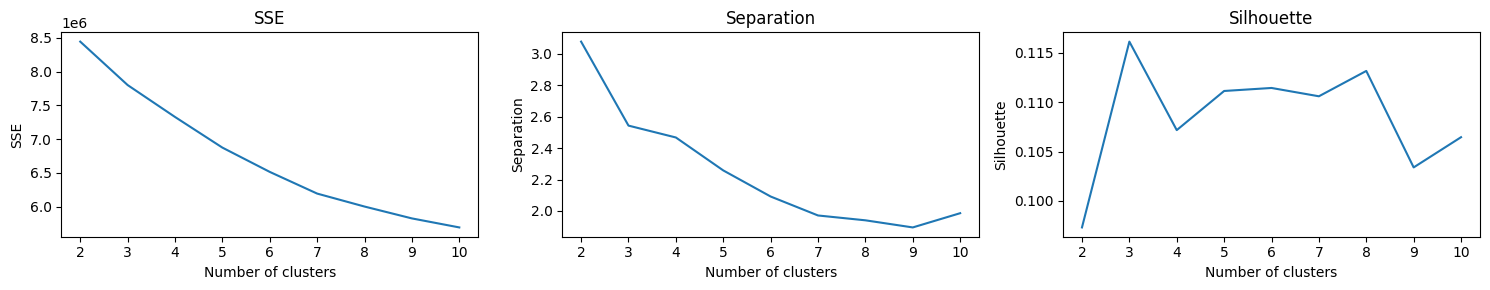

In [218]:
scores_dict = scores(models=models, df=df_s, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

In [219]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=df_s, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

k = 3


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:51<00:00, 10.37s/it]


Best mean silhouette score for k = 3:
SSE = 7800450.256698627
Separation = 2.543623634825016
Silhouette = 0.11526938640247453


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


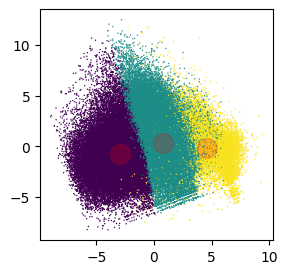

Cluster 0: 53574 points
Cluster 1: 124516 points
Cluster 2: 12887 points


In [220]:
best_model = models[best_k]

points_pca_s, centroids_pca_s = perform_PCA(df=df_s, centroids=best_model.cluster_centers_, n_components=2)

plt.figure(figsize=(3, 3))

plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', s=200, alpha=0.2)

plt.show()

cluster_labels, cluster_counts = np.unique(best_model.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### K-means on the reduced augmented dataset
(the same as with the reduced original dataset)

In [224]:
k_min = 2
k_max = 10

models = k_means(df=reduced, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 9/9 [00:24<00:00,  2.76s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:16<00:00,  5.40s/it]


k = 3


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


k = 4


100%|██████████| 3/3 [00:15<00:00,  5.08s/it]


k = 5


100%|██████████| 3/3 [00:17<00:00,  5.85s/it]


k = 6


100%|██████████| 3/3 [00:20<00:00,  6.93s/it]


k = 7


100%|██████████| 3/3 [00:16<00:00,  5.65s/it]


k = 8


100%|██████████| 3/3 [00:17<00:00,  5.68s/it]


k = 9


100%|██████████| 3/3 [00:17<00:00,  5.75s/it]


k = 10


100%|██████████| 3/3 [00:17<00:00,  5.79s/it]


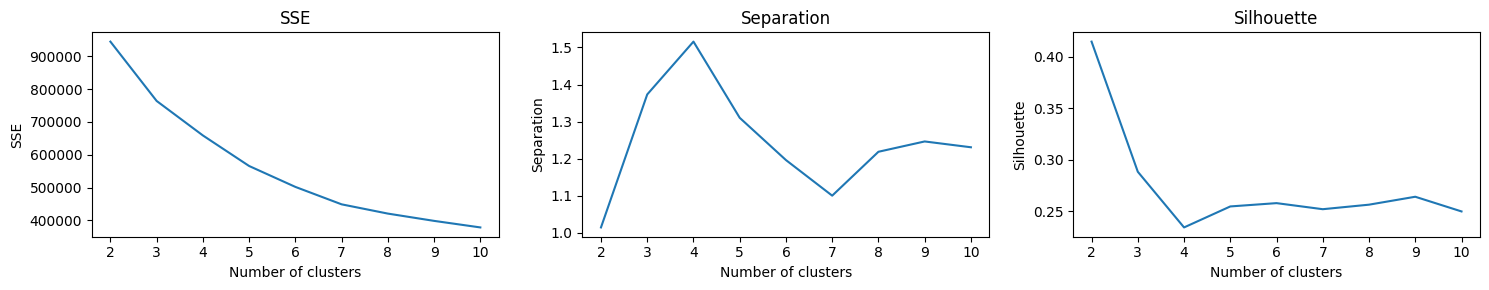

In [225]:
scores_dict = scores(models=models, df=reduced, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

In [226]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=reduced, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:32<00:00, 18.49s/it]


Best mean silhouette score for k = 2:
SSE = 944734.0845960035
Separation = 1.014701571838864
Silhouette = 0.4123683229308628


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


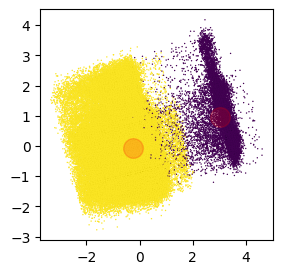

Cluster 0: 13263 points
Cluster 1: 177714 points


In [227]:
best_model_r = models[best_k]

points_pca, centroids_pca = perform_PCA(df=reduced, centroids=best_model_r.cluster_centers_, n_components=2)

plt.figure(figsize=(3, 3))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model_r.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.show()

cluster_labels, cluster_counts = np.unique(best_model_r.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### + Trying with only indicators

Idicator dataset dimentions: (190977, 21)


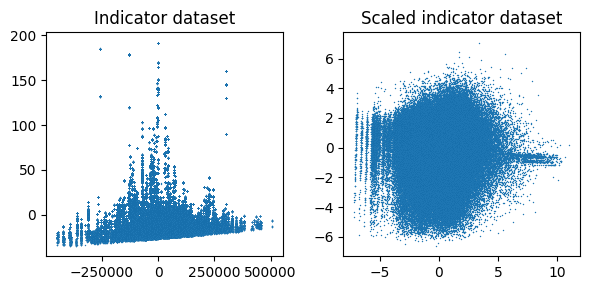

In [238]:
df_ind = df[['month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_incidents',
       'month_cd_votes_incidents', 'cd_population', 'percentage_republican',
       'percentage_democrat', 'cd_month_SHOT_INJURED', 'cd_month_SHOT_DEAD',
       'cd_month_NON_SHOOTING', 'cd_month_SHOTS_FIRED_UNHARMED',
       'cd_month_OTHER']]

scaler_ind = StandardScaler()
df_ind_s = scaler.fit_transform(df_ind)
df_ind_s = pd.DataFrame(df_ind_s, columns=df_ind.columns)

print(f'Idicator dataset dimentions: {df_ind.shape}')

pca = perform_PCA(df=df_ind, n_components=2)
pca_s = perform_PCA(df=df_ind_s, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Indicator dataset')

plt.subplot(1, 2, 2)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled indicator dataset')

plt.tight_layout()
plt.show()

Initial n_cols = 21

Survived columns (variance_threshold = 1):----------------------------------------------
n_cols = 21
Index(['month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_incidents',
       'month_cd_votes_incidents', 'cd_population', 'percentage_republican',
       'percentage_democrat', 'cd_month_SHOT_INJURED', 'cd_month_SHOT_DEAD',
       'cd_month_NON_SHOOTING', 'cd_month_SHOTS_FIRED_UNHARMED',
       'cd_month_OTHER'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 6
Index(['month_cd_change_min_age_participants', 'month_cd_ratio_males',
       'month_

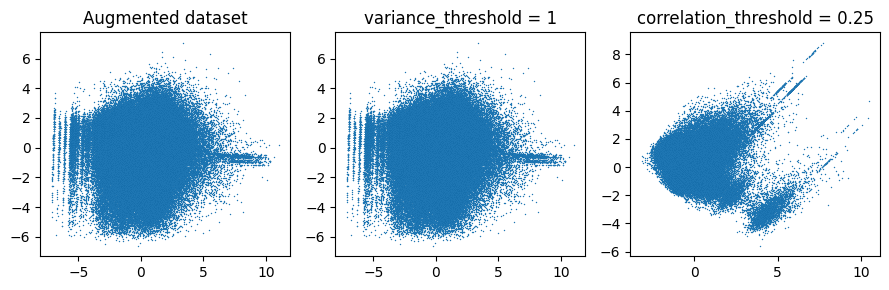

In [239]:
var_thr = 1
reduced_ind_var = features_reduction_var(df_ind_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_ind_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_ind_var.columns)}')
print(reduced_ind_var.columns)

corr_thr = 0.25
reduced_ind = features_reduction_corr(reduced_ind_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_ind.columns)}')
print(reduced_ind.columns)

pca_v = perform_PCA(df=reduced_ind_var, n_components=2)
pca_c = perform_PCA(df=reduced_ind, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_v[:, 0], pca_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_c[:, 0], pca_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

#### K-means on the full indicator dataset

In [240]:
k_min = 2
k_max = 10

models = k_means(df=df_ind_s, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 9/9 [00:41<00:00,  4.57s/it]


k = 2


100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


k = 3


100%|██████████| 3/3 [00:10<00:00,  3.35s/it]


k = 4


100%|██████████| 3/3 [00:06<00:00,  2.28s/it]


k = 5


100%|██████████| 3/3 [00:06<00:00,  2.25s/it]


k = 6


100%|██████████| 3/3 [00:06<00:00,  2.23s/it]


k = 7


100%|██████████| 3/3 [00:06<00:00,  2.23s/it]


k = 8


100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


k = 9


100%|██████████| 3/3 [00:07<00:00,  2.38s/it]


k = 10


100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


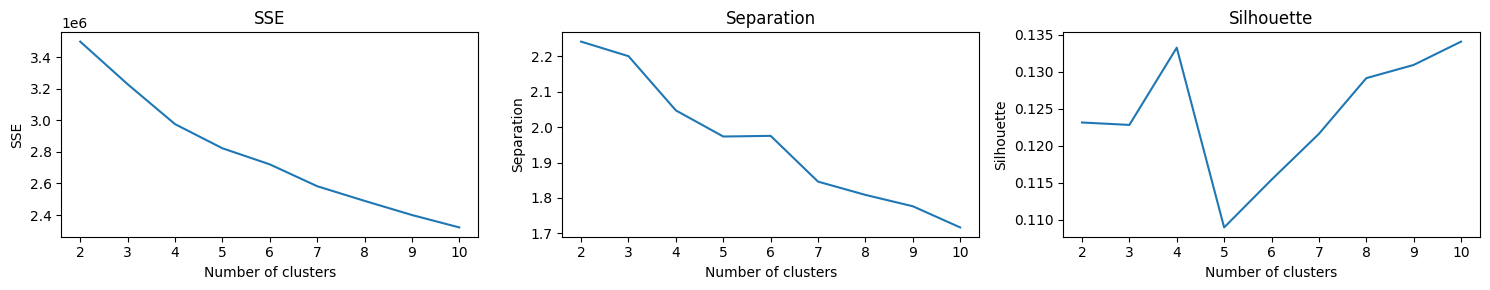

In [241]:
scores_dict = scores(models=models, df=df_ind_s, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

In [242]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=df_ind_s, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

k = 10


100%|██████████| 5/5 [00:51<00:00, 10.35s/it]


Best mean silhouette score for k = 10:
SSE = 2321460.6974242013
Separation = 1.716912712990445
Silhouette = 0.13565954509073505


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


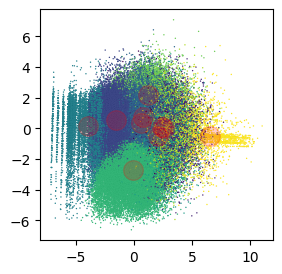

Cluster 0: 13077 points
Cluster 1: 6831 points
Cluster 2: 48811 points
Cluster 3: 56177 points
Cluster 4: 12764 points
Cluster 5: 9327 points
Cluster 6: 29630 points
Cluster 7: 4735 points
Cluster 8: 7366 points
Cluster 9: 2259 points


In [243]:
best_model_ind = models[best_k]

points_pca_s, centroids_pca_s = perform_PCA(df=df_ind_s, centroids=best_model_ind.cluster_centers_, n_components=2)

plt.figure(figsize=(3, 3))

plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=best_model_ind.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', s=200, alpha=0.2)

plt.show()

cluster_labels, cluster_counts = np.unique(best_model_ind.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### K-means on the reduced indicator dataset

In [244]:
k_min = 2
k_max = 10

models = k_means(df=reduced_ind, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 9/9 [00:31<00:00,  3.46s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:11<00:00,  3.75s/it]


k = 3


100%|██████████| 3/3 [00:10<00:00,  3.46s/it]


k = 4


100%|██████████| 3/3 [00:12<00:00,  4.09s/it]


k = 5


100%|██████████| 3/3 [00:11<00:00,  3.68s/it]


k = 6


100%|██████████| 3/3 [00:13<00:00,  4.47s/it]


k = 7


100%|██████████| 3/3 [00:11<00:00,  3.70s/it]


k = 8


100%|██████████| 3/3 [00:11<00:00,  3.73s/it]


k = 9


100%|██████████| 3/3 [00:11<00:00,  3.71s/it]


k = 10


100%|██████████| 3/3 [00:13<00:00,  4.60s/it]


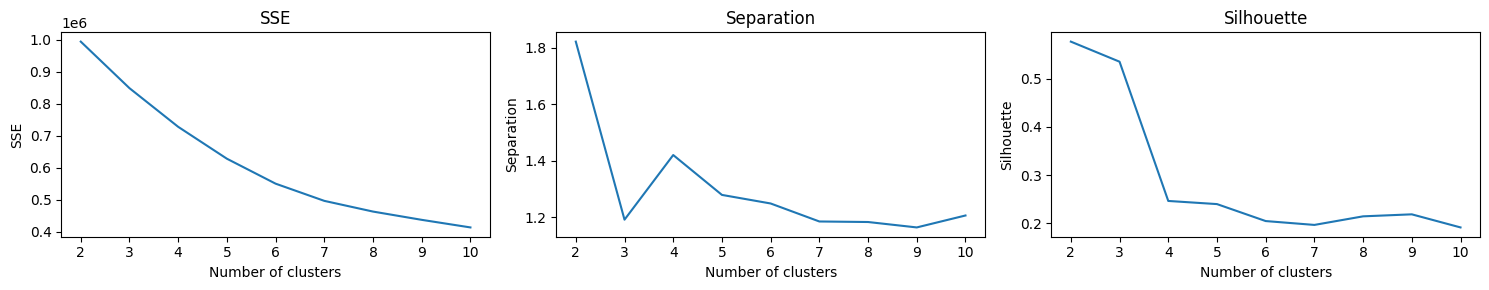

In [247]:
scores_dict = scores(models=models, df=reduced_ind, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

In [248]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=reduced_ind, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

k = 2


100%|██████████| 5/5 [00:56<00:00, 11.27s/it]


Best mean silhouette score for k = 2:
SSE = 994469.005035937
Separation = 1.8221097850015722
Silhouette = 0.5751436938995302


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


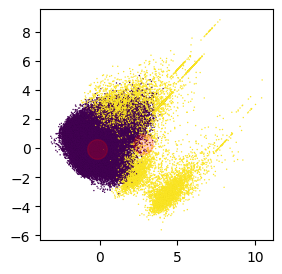

Cluster 0: 179417 points
Cluster 1: 11560 points


In [249]:
best_model_ind_r = models[best_k]

points_pca_s, centroids_pca_s = perform_PCA(df=reduced_ind, centroids=best_model_ind_r.cluster_centers_, n_components=2)

plt.figure(figsize=(3, 3))

plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=best_model_ind_r.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', s=200, alpha=0.2)

plt.show()

cluster_labels, cluster_counts = np.unique(best_model_ind_r.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

## Analysis

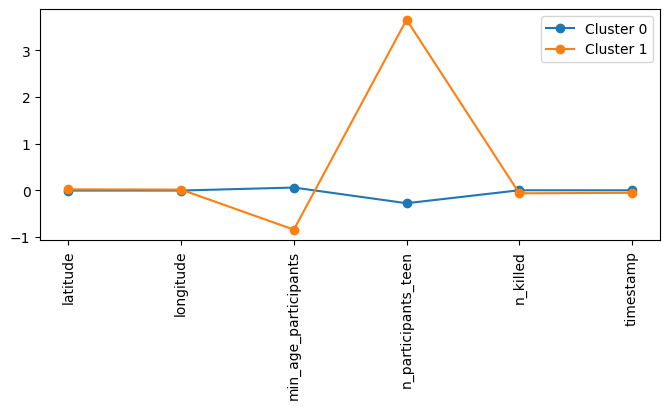

In [117]:
centers = best_model.cluster_centers_
cols = reduced.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

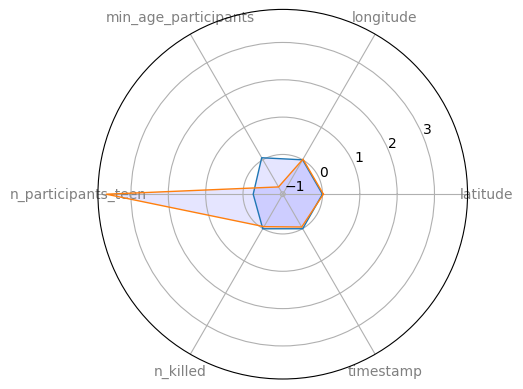

In [118]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=10) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [120]:
cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party']

df_c =  df_init[df_init['OUTLIER'] == 0]
df_c = df_c[cat_cols]

In [121]:
party_xt_pct = pd.crosstab(best_model.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0        101922       75792
1          7592        5671

In [122]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.573517    0.426483
1  0.572420    0.427580

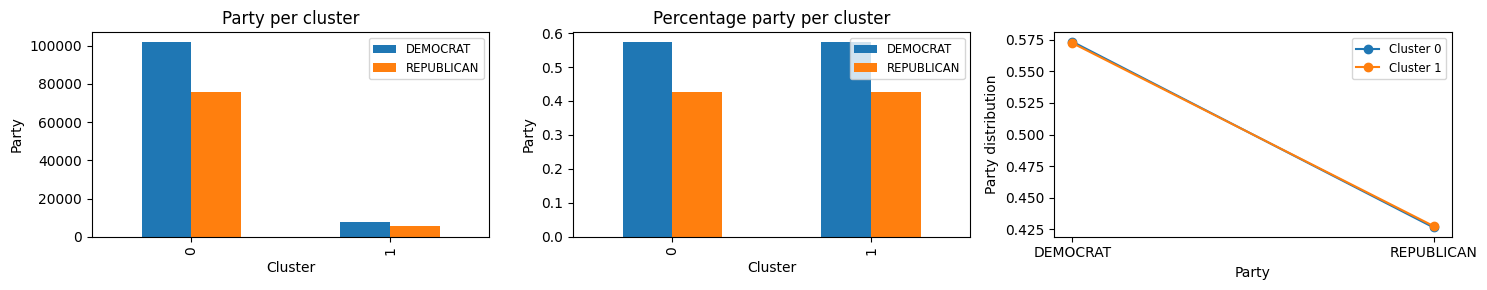

In [156]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [130]:
day_xt_pct = pd.crosstab(best_model.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         6460  5628  5716  5811  5901  5817  5743  5791  5640  5570  ...   
1          500   402   417   405   450   412   428   398   427   442  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         5645  5842  5605  6031  5908  5974  5881  5526  5384  3543  
1          436   394   451   444   445   413   442   417   422   273  

[2 rows x 31 columns]

In [131]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.036351  0.031669  0.032164  0.032699  0.033205  0.032732  0.032316   
1  0.037699  0.030310  0.031441  0.030536  0.033929  0.031064  0.032270   

         8         9         10  ...        22        23        24        25  \
0  0.032586  0.031736  0.031342  ...  0.031765  0.032873  0.031539  0.033937   
1  0.030008  0.032195  0.033326  ...  0.032873  0.029707  0.034004  0.033477   

         26        27        28        29        30        31  
0  0.033244  0.033616  0.033092  0.031095  0.030296  0.019937  
1  0.033552  0.031139  0.033326  0.031441  0.031818  0.020584  

[2 rows x 31 columns]

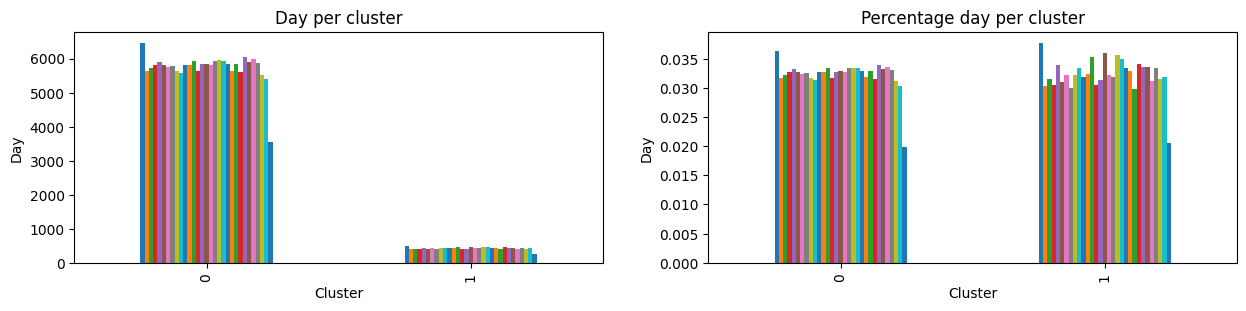

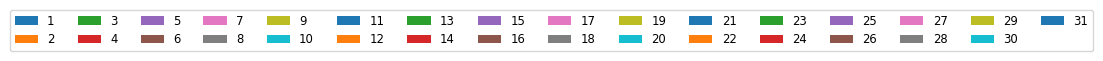

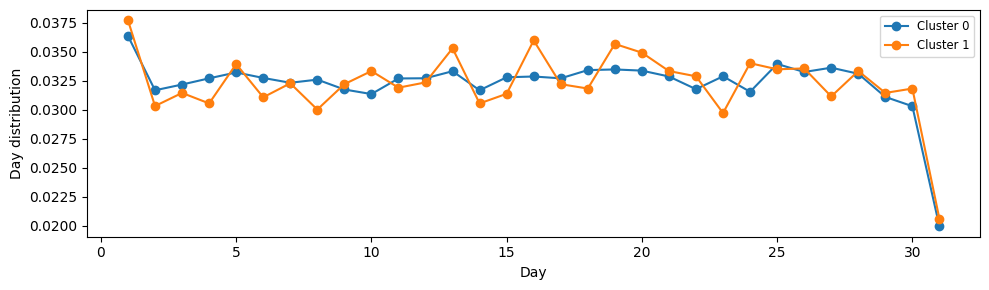

In [150]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [141]:
month_xt_pct = pd.crosstab(best_model.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3      4      5      6      7      8      9   \
row_0                                                                       
0           17245  14211  16994  13492  14528  13584  15276  15568  14345   
1            1265   1032   1281   1048   1072    980   1175   1111   1063   

date_month     10     11     12  
row_0                            
0           14662  13347  14462  
1            1156   1026   1054

In [142]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.097038  0.079966  0.095626  0.075920  0.081749  0.076437  0.085958   
1  0.095378  0.077810  0.096584  0.079017  0.080826  0.073890  0.088592   

         8         9         10        11        12  
0  0.087601  0.080720  0.082503  0.075104  0.081378  
1  0.083767  0.080148  0.087160  0.077358  0.079469

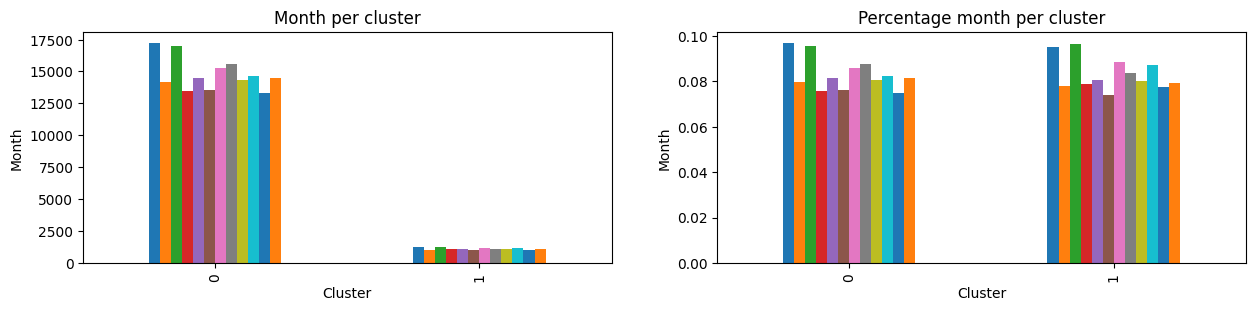

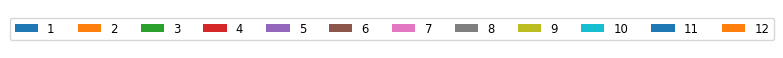

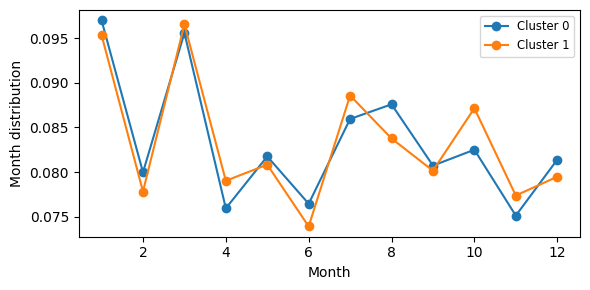

In [153]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [146]:
year_xt_pct = pd.crosstab(best_model.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0              39   29574   36616   48975   51217   11293
1               2    2218    2806    3716    3715     806

In [147]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000219  0.166413  0.206039  0.275583  0.288199  0.063546
1  0.000151  0.167232  0.211566  0.280178  0.280103  0.060771

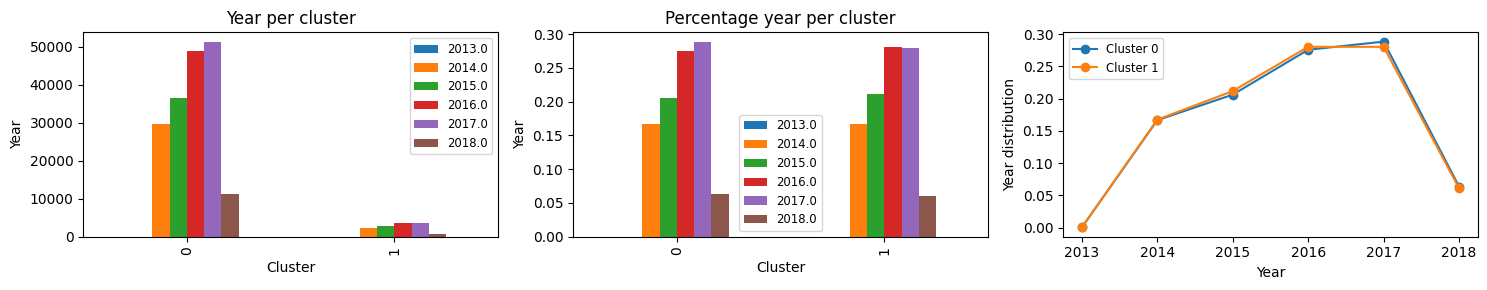

In [154]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [157]:
state_xt_pct = pd.crosstab(best_model.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         4026     147     1793      2254        9587      2666         2595   
1          311      10      117       158         703       199          180   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0          1330    10417     6740  ...           448       5706   8842   793   
1           105      812      516  ...            42        442    688    59   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          367      4502        2611           1251       3921      419  
1           18       348         212             74        272       32  

[2 rows x 50 columns]

In [158]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.022654  0.000827  0.010089  0.012683    0.053946  0.015002     0.014602   
1  0.023449  0.000754  0.008822  0.011913    0.053005  0.015004     0.013572   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.007484  0.058617  0.037926  ...      0.002521   0.032108  0.049754   
1  0.007917  0.061223  0.038905  ...      0.003167   0.033326  0.051874   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004462  0.002065  0.025333    0.014692       0.007039   0.022064   
1  0.004448  0.001357  0.026238    0.015984       0.005579   0.020508   

    WYOMING  
0  0.002358  
1  0.002413  

[2 rows x 50 columns]

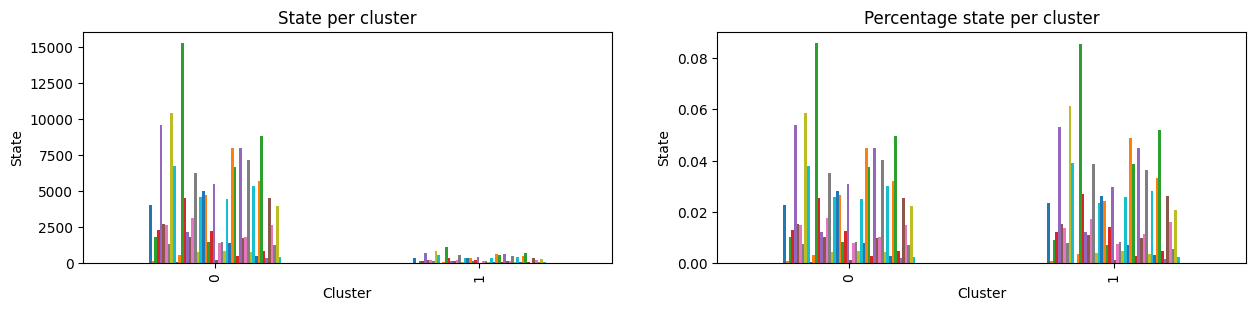

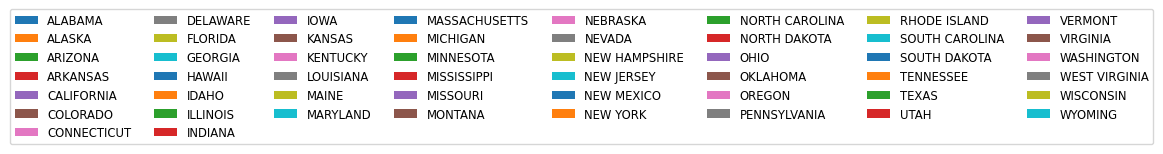

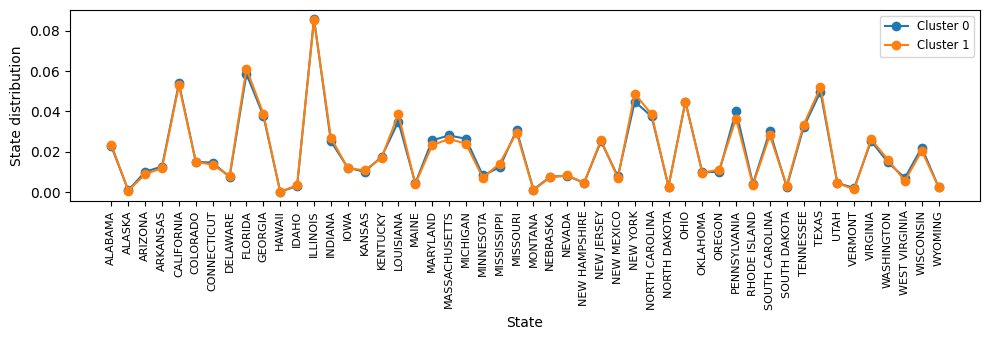

In [162]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [164]:
ic_xt_pct = pd.crosstab(best_model.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   5484                  319   
1                                    387                   20   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 4                 20   
1                                                 0                  1   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                  238                            27   
1                                   20                             1   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                     32                180        60   
1                                      4                 12         2   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       775  ...                 225   
1                                        70  ...                  14   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     4               3         613       29   
1                                     0               0          47        1   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       69        1882                5   
1                                        2         116                0   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                    1062                       1  
1                                      73                       0  

[2 rows x 49 columns]

In [165]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.030859             0.001795                  0.000023   
1       0.029179             0.001508                  0.000000   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000113     0.001339                      0.000152   
1           0.000075     0.001508                      0.000075   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000180           0.001013  0.000338          0.004361  ...   
1       0.000302           0.000905  0.000151          0.005278  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001266      0.000023        0.000017    0.003449  0.000163   
1            0.001056      0.000000        0.000000    0.003544  0.000075   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000388    0.010590         0.000028        0.005976   
1         0.000151    0.008746         0.000000        0.005504   

   UNLAWFUL_PURCHASE_SALE  
0                0.000006  
1                0.000000  

[2 rows x 49 columns]

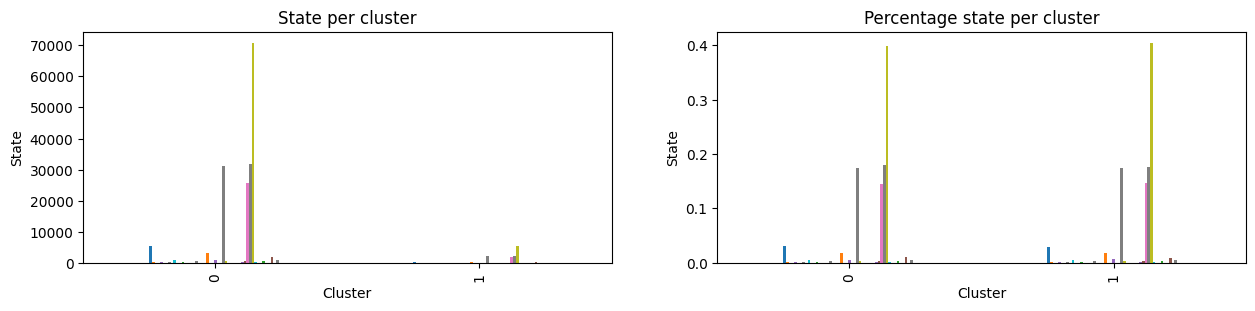

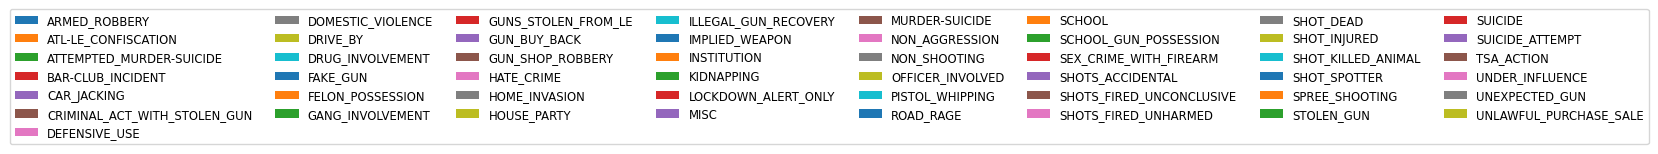

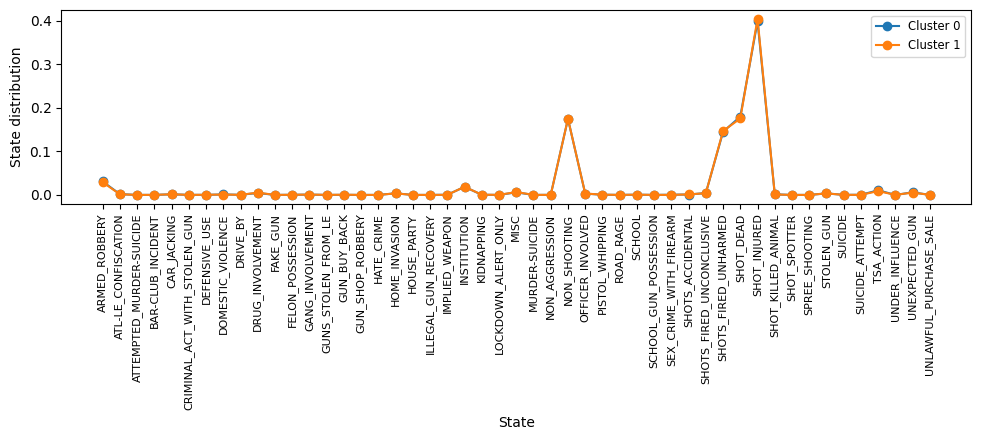

In [172]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [547]:
df_only_ind = df_no_out_s[['month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_incidents',
       'month_cd_votes_incidents', 'cd_population', 'percentage_republican',
       'percentage_democrat', 'cd_month_SHOT_INJURED', 'cd_month_SHOT_DEAD',
       'cd_month_NON_SHOOTING', 'cd_month_SHOTS_FIRED_UNHARMED',
       'cd_month_OTHER']]
df_only_ind.shape

(190977, 21)

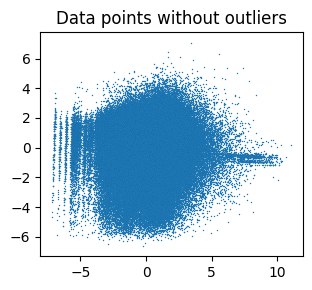

In [545]:
pca_only_ind = perform_PCA(df=df_only_ind, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca_only_ind[:, 0], pca_only_ind[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.tight_layout()
plt.show()

In [550]:
reduced_only_ind_var = features_reduction_var(df_only_ind, variance_threshold=1)
print('Survived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_only_ind_var.columns)}')
print(reduced_only_ind_var.columns)

Survived columns (without outliers):----------------------------------------------
n_cols = 21
Index(['month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_incidents',
       'month_cd_votes_incidents', 'cd_population', 'percentage_republican',
       'percentage_democrat', 'cd_month_SHOT_INJURED', 'cd_month_SHOT_DEAD',
       'cd_month_NON_SHOOTING', 'cd_month_SHOTS_FIRED_UNHARMED',
       'cd_month_OTHER'],
      dtype='object')


In [575]:
reduced_only_ind = features_reduction_corr(reduced_only_ind_var, correlation_threshold=0.25)
print('Survived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_only_ind.columns)}')
print(reduced_only_ind.columns)

Survived columns (without outliers):----------------------------------------------
n_cols = 6
Index(['month_cd_change_min_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'cd_population', 'cd_month_SHOT_DEAD'],
      dtype='object')


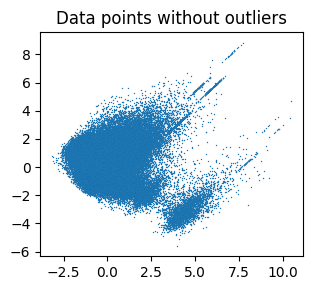

In [576]:
pca_only_ind = perform_PCA(df=reduced_only_ind, n_components=2)


plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca_only_ind[:, 0], pca_only_ind[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.tight_layout()
plt.show()

In [594]:
k_min = 2
k_max = 10

modelss, sampless = k_means(df=reduced_only_ind, k_min=k_min, k_max=k_max, max_iter=300)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:30<00:00,  3.44s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


k = 3


100%|██████████| 3/3 [00:12<00:00,  4.30s/it]


k = 4


100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


k = 5


100%|██████████| 3/3 [00:08<00:00,  2.72s/it]


k = 6


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


k = 7


100%|██████████| 3/3 [00:12<00:00,  4.17s/it]


k = 8


100%|██████████| 3/3 [00:13<00:00,  4.48s/it]


k = 9


100%|██████████| 3/3 [00:11<00:00,  3.89s/it]


k = 10


100%|██████████| 3/3 [00:08<00:00,  2.90s/it]


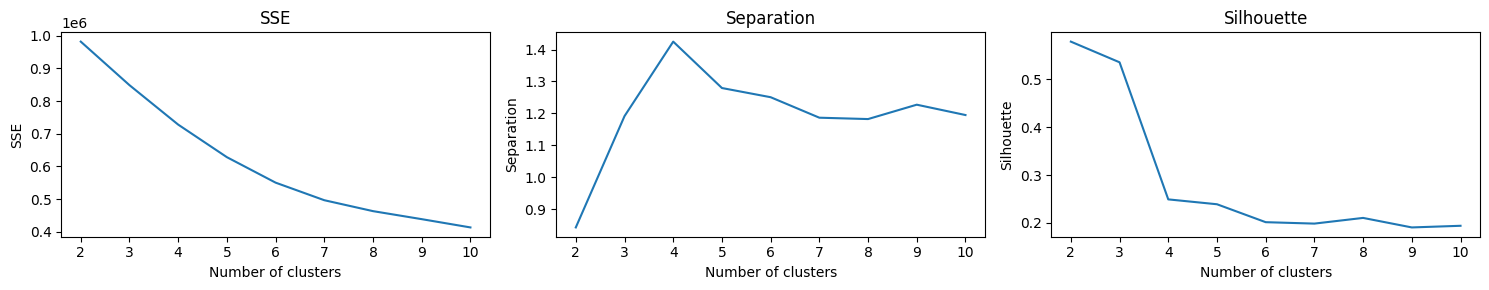

In [595]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scoress_dict=scoress_dict, k_min=k_min, k_max=k_max)

In [596]:
best_k = np.argmax(mean_scores)+k_min

scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:56<00:00, 11.36s/it]


Best mean silhouette score for k = 2:
SSE = 982290.5241152765
Separation = 0.84233579943193
Silhouette = 0.5724854651945607


In [597]:
modelss, sampless = k_means(reduced_only_ind, k_min=best_k, k_max=best_k, max_iter=1000000)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


In [598]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nk = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:11<00:00, 14.20s/it]


k = 2:
SSE = 982290.5241152748
Separation = 0.8423357994319317
Silhouette = 0.5772990414695046


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


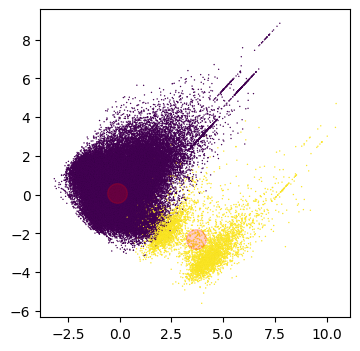

Cluster 0: 185684 points
Cluster 1: 5293 points


In [602]:
best_model = modelss[best_k][0]

best_model_samples = sampless[best_k][0]

points_pca, centroids_pca = perform_PCA(df=best_model_samples, centroids=best_model.cluster_centers_, n_components=2)

plt.figure(figsize=(4, 4))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.show()

cluster_labels, cluster_counts = np.unique(best_model.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

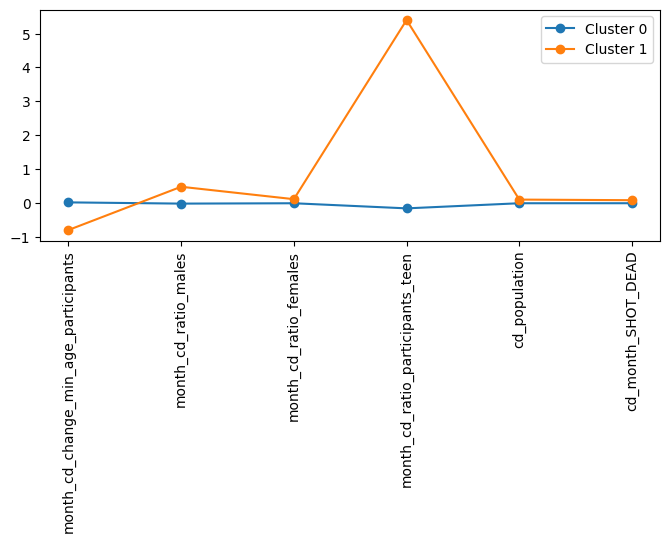

In [613]:
centers = best_model.cluster_centers_
cols = reduced_only_ind.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation=90)
plt.legend()
plt.show()

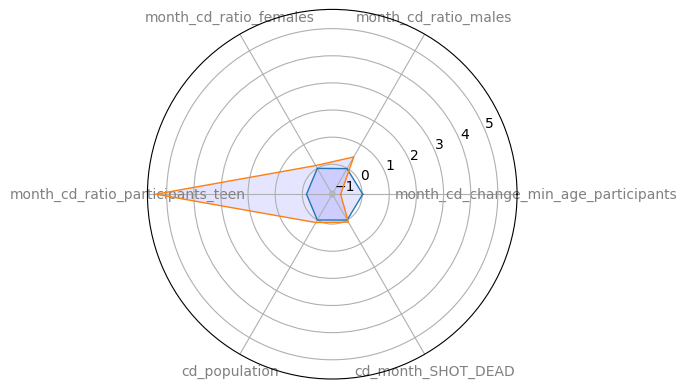

In [614]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=10) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [628]:
df_c =  df[df['OUTLIER'] == 0]
df_c = df_c[cat_cols]

In [629]:
party_xt_pct = pd.crosstab(best_model.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0        106444       79240
1          3070        2223

In [617]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.573253    0.426747
1  0.580011    0.419989

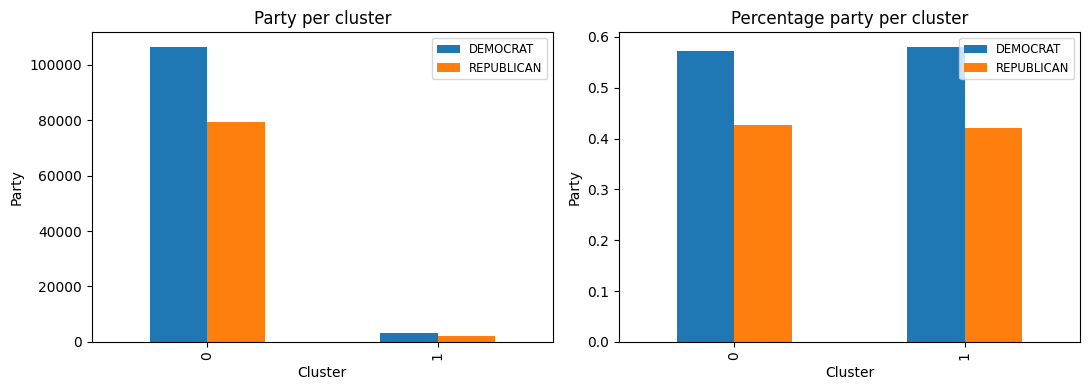

In [618]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small', loc='upper right')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small', loc='upper right')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

plt.tight_layout()
plt.show()

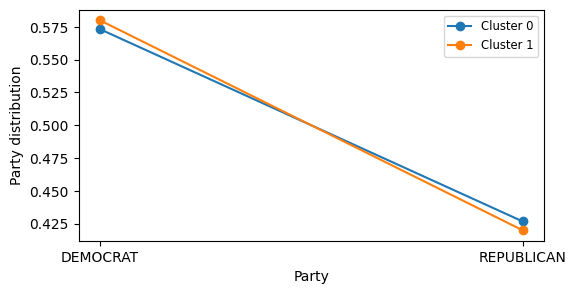

In [619]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Party')
ax.set_ylabel('Party distribution')
ax.set_title(f'')

plt.show()

In [630]:
day_xt_pct = pd.crosstab(best_model.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         6741  5869  5978  6034  6174  6074  6011  6007  5915  5827  ...   
1          219   161   155   182   177   155   160   182   152   185  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         5933  6077  5889  6301  6157  6217  6154  5785  5644  3708  
1          148   159   167   174   196   170   169   158   162   108  

[2 rows x 31 columns]

In [631]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4        5         6         7   \
0  0.036304  0.031607  0.032194  0.032496  0.03325  0.032711  0.032372   
1  0.041375  0.030418  0.029284  0.034385  0.03344  0.029284  0.030229   

         8         9         10  ...        22        23        24        25  \
0  0.032351  0.031855  0.031381  ...  0.031952  0.032728  0.031715  0.033934   
1  0.034385  0.028717  0.034952  ...  0.027961  0.030040  0.031551  0.032874   

         26        27        28        29        30        31  
0  0.033158  0.033482  0.033142  0.031155  0.030396  0.019969  
1  0.037030  0.032118  0.031929  0.029851  0.030606  0.020404  

[2 rows x 31 columns]

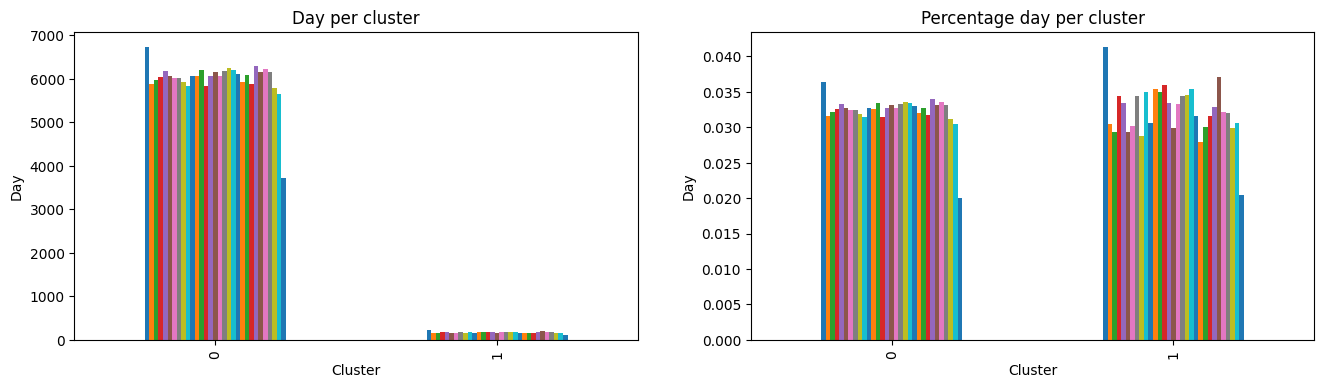

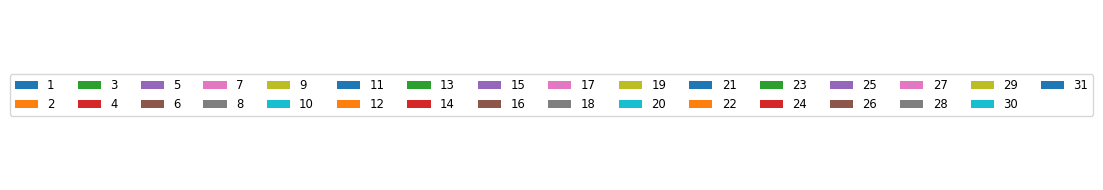

In [632]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 2))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

plt.tight_layout()
plt.show()

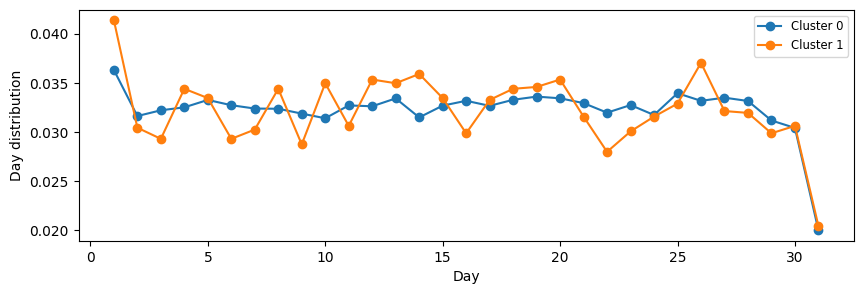

In [633]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.show()

In [634]:
month_xt_pct = pd.crosstab(best_model.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3      4      5      6      7      8      9   \
row_0                                                                       
0           18004  14815  17764  14109  15152  14145  16040  16198  14995   
1             506    428    511    431    448    419    411    481    413   

date_month     10     11     12  
row_0                            
0           15371  14004  15087  
1             447    369    429

In [635]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.096960  0.079786  0.095668  0.075984  0.081601  0.076178  0.086383   
1  0.095598  0.080862  0.096543  0.081428  0.084640  0.079161  0.077650   

         8         9         10        11        12  
0  0.087234  0.080755  0.082780  0.075418  0.081251  
1  0.090875  0.078028  0.084451  0.069715  0.081050

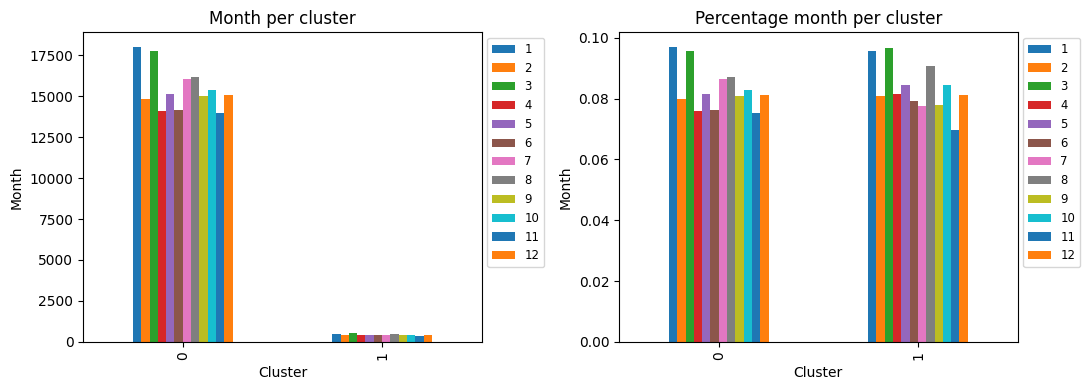

In [636]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend(fontsize='small', bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend(fontsize='small', bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

plt.tight_layout()
plt.show()

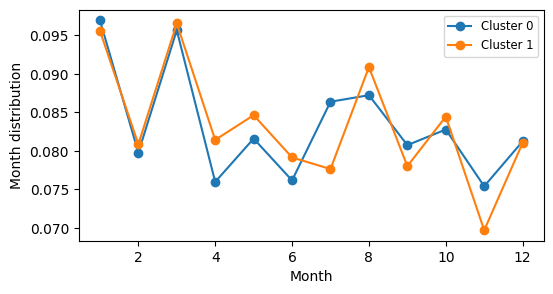

In [637]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.show()

In [ ]:
year_xt_pct = pd.crosstab(best_model.labels_, df_c['date_year'])
year_xt_pct

In [638]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000203  0.166436  0.206354  0.275617  0.287856  0.063535
1  0.000377  0.166931  0.207344  0.279726  0.284702  0.060921

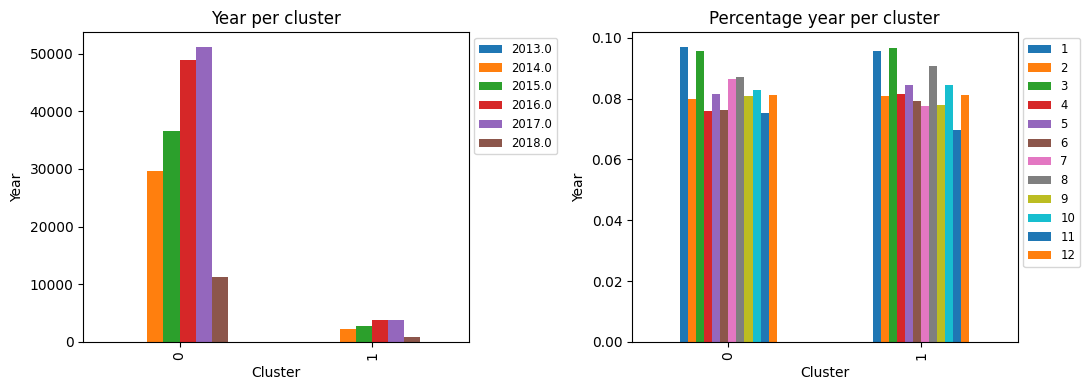

In [639]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small', bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small', bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Year')

plt.tight_layout()
plt.show()

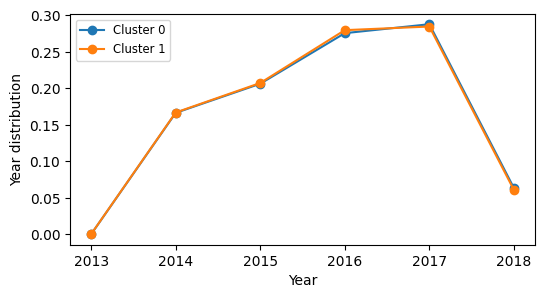

In [640]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Year')
ax.set_ylabel('Year distribution')
ax.set_title(f'')

plt.show()

In [641]:
state_xt_pct = pd.crosstab(best_model.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         4231     155     1860      2352        9996      2775         2682   
1          106       2       50        60         294        90           93   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0          1400    10922     7036  ...           482       5966   9273   830   
1            35      307      220  ...             8        182    257    22   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          374      4727        2735           1302       4078      438  
1           11       123          88             23        115       13  

[2 rows x 50 columns]

In [642]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.022786  0.000835  0.010017  0.012667    0.053833  0.014945     0.014444   
1  0.020026  0.000378  0.009446  0.011336    0.055545  0.017004     0.017570   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.007540  0.058820  0.037892  ...      0.002596   0.032130  0.049940   
1  0.006613  0.058001  0.041564  ...      0.001511   0.034385  0.048555   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004470  0.002014  0.025457    0.014729       0.007012   0.021962   
1  0.004156  0.002078  0.023238    0.016626       0.004345   0.021727   

    WYOMING  
0  0.002359  
1  0.002456  

[2 rows x 50 columns]

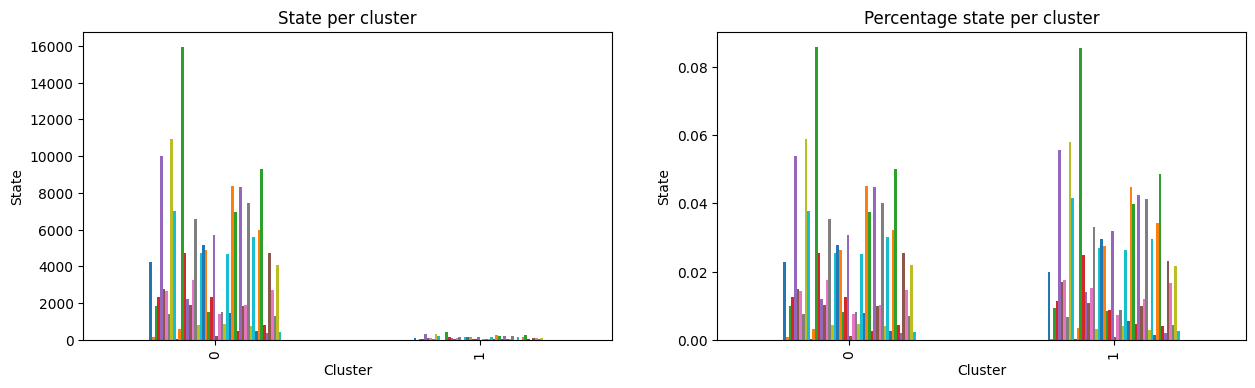

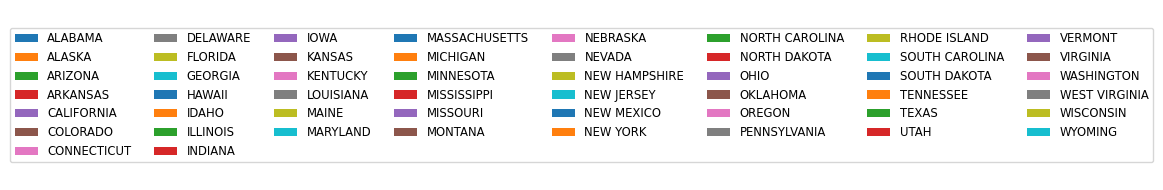

In [643]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 2))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

plt.tight_layout()
plt.show()

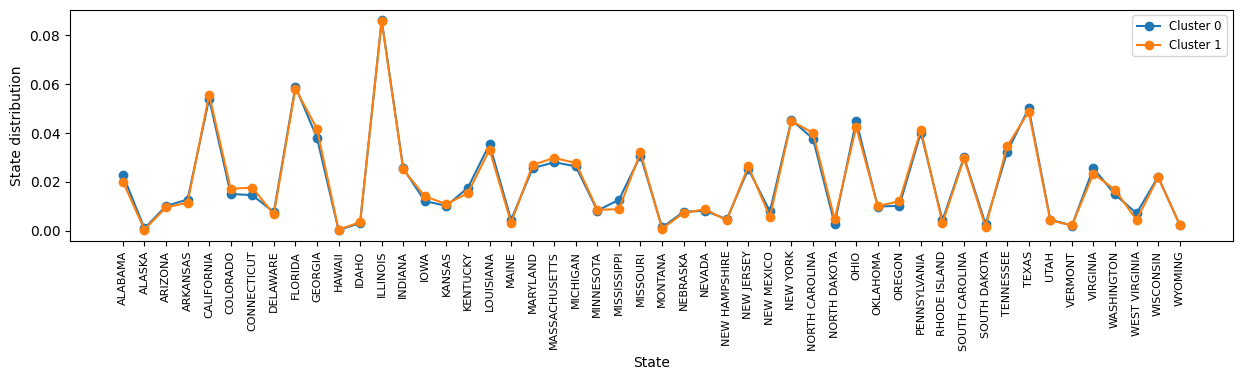

In [644]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, ax = plt.subplots(figsize=(15, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.show()

In [645]:
ic_xt_pct = pd.crosstab(best_model.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   5717                  328   
1                                    154                   11   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 4                 20   
1                                                 0                  1   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                  250                            28   
1                                    8                             0   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                     33                185        59   
1                                      3                  7         3   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       827  ...                 232   
1                                        18  ...                   7   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     3               3         645       29   
1                                     1               0          15        1   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       70        1946                5   
1                                        1          52                0   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                    1099                       1  
1                                      36                       0  

[2 rows x 49 columns]

In [646]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.030789             0.001766                  0.000022   
1       0.029095             0.002078                  0.000000   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000108     0.001346                      0.000151   
1           0.000189     0.001511                      0.000000   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000178           0.000996  0.000318          0.004454  ...   
1       0.000567           0.001323  0.000567          0.003401  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001249      0.000016        0.000016    0.003474  0.000156   
1            0.001323      0.000189        0.000000    0.002834  0.000189   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000377    0.010480         0.000027        0.005919   
1         0.000189    0.009824         0.000000        0.006801   

   UNLAWFUL_PURCHASE_SALE  
0                0.000005  
1                0.000000  

[2 rows x 49 columns]

/tmp/ipykernel_24514/2204329852.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


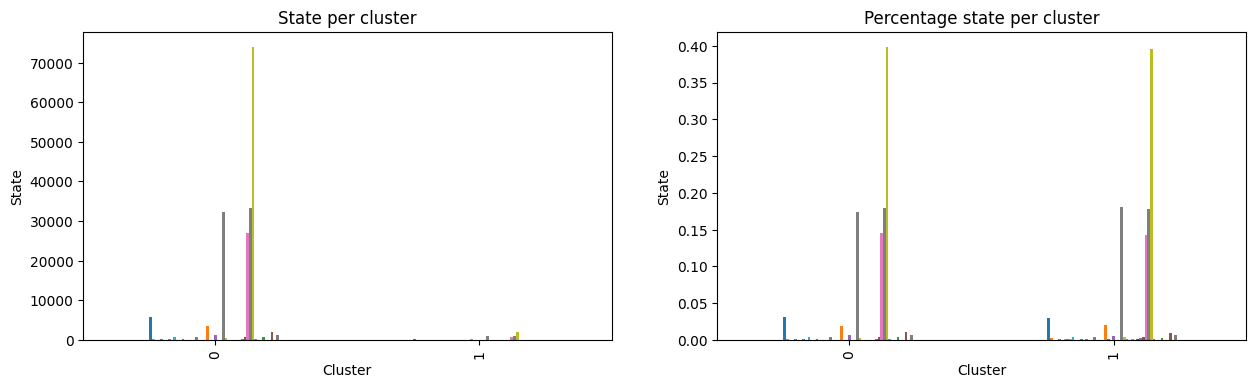

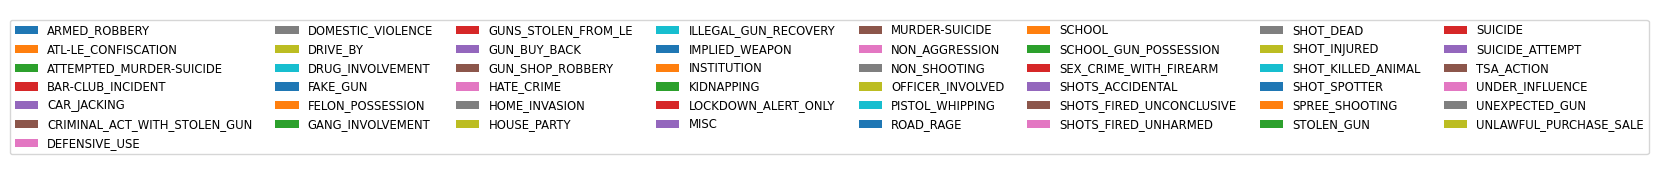

In [647]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 2))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

plt.tight_layout()
plt.show()

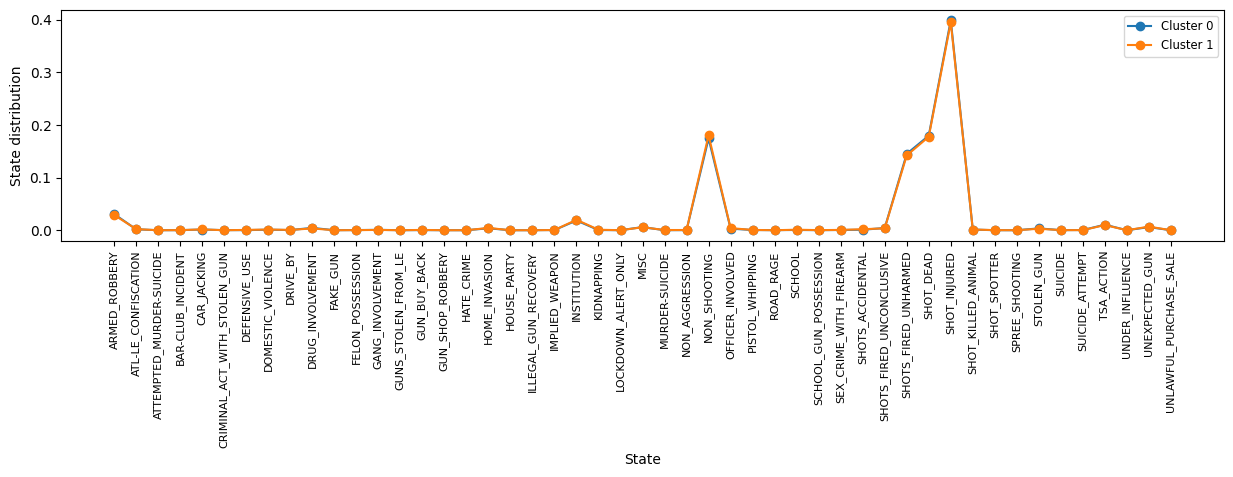

In [648]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, ax = plt.subplots(figsize=(15, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.show()